In [3]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching et3_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s et3_Scene"

In [181]:
class Eye(VMobject):
    def __init__(self, position, size, **kwargs):
        super().__init__(**kwargs)
        self.eye_center = position
        self.eye_radius = size
        circle = Circle(radius = self.eye_radius, color = DARK_GREY, stroke_width = 15.0).move_to(self.eye_center)
        self.add(circle)

    # returns the pupil
    def get_pupil(self, pupil_size, pupil_pradius, pupil_angle):
        pupil_radius = pupil_pradius * (self.eye_radius - pupil_size)
        self.pupil_center = self.eye_center + np.array([pupil_radius*np.cos(pupil_angle), pupil_radius*np.sin(pupil_angle), 0])
        pupil_circle = Circle(radius = pupil_size, fill_opacity = 1).move_to(self.pupil_center).set_color(BLACK)
        return pupil_circle
    
    # returns cornea reflection
    def get_reflection(self, reflect_pradius, reflect_angle):
        reflect_radius = reflect_pradius * self.eye_radius
        self.reflect_center = self.eye_center + np.array([reflect_radius*np.cos(reflect_angle), reflect_radius*np.sin(reflect_angle), 0])
        reflect_dot = Dot(point = self.reflect_center, radius = 0.1, fill_opacity = 0.8).set_color([PURE_RED, RED])
        cross_length = 0.75
        reflect_horizontal = Line(start = self.reflect_center - cross_length*RIGHT, end = self.reflect_center + cross_length*RIGHT, stroke_width = 2, color = RED)
        reflect_vertical = Line(start = self.reflect_center - cross_length*UP, end = self.reflect_center + cross_length*UP, stroke_width = 2, color = RED)
        return VGroup(reflect_dot, reflect_horizontal, reflect_vertical)
        #return reflect_dot
    
    def get_connector(self):
        connect_vector = Line(start = self.reflect_center, end = self.pupil_center, color = BLUE).add_tip(tip_length = 0.25, tip_width = 0.25)
        return connect_vector


class Screen(VMobject):
    def __init__(self, position, height, width, **kwargs):
        super().__init__(**kwargs)
        rectangle = Rectangle(height = height, width = width, stroke_width = 4, color = BLACK).move_to(position)
        self.add(rectangle)

        dot_center = Dot(position, radius = 0.1, color = GREY)
        dot_top_left = Dot(position + height/2*UP - width/2*RIGHT + height/8*(DOWN+RIGHT), radius = 0.1, color = GREY)
        dot_bottom_left = Dot(position - height/2*UP - width/2*RIGHT + height/8*(UP+RIGHT), radius = 0.1, color = GREY)
        dot_bottom_right = Dot(position - height/2*UP + width/2*RIGHT + height/8*(UP+LEFT), radius = 0.1, color = GREY)
        dot_top_right = Dot(position + height/2*UP + width/2*RIGHT + height/8*(DOWN+LEFT), radius = 0.1, color = GREY)
        self.add(dot_center, dot_top_left, dot_bottom_left, dot_bottom_right, dot_top_right)

Output saved by overwring previous file at animations/eye_tracking_3/eye_tracking_3.mp4.


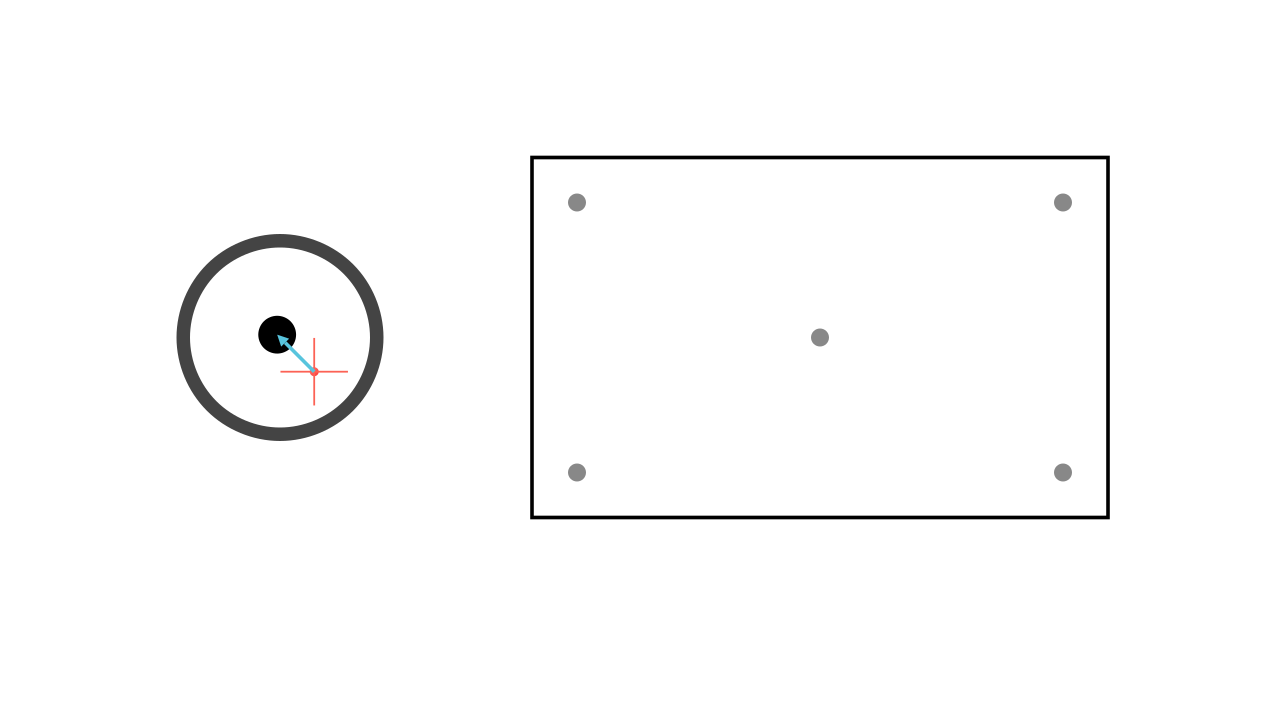

In [182]:
%%capture_video --path "animations/eye_tracking_3/eye_tracking_3.mp4"
%%manim -qm --fps 60 $video_scene


class et3_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        # human eye to graphic transition
        human_eye = ImageMobject("external_media/Eye1.jpg")
        #self.add(human_eye)

        eye = Eye(position = np.array([0, 0.25, 0]), size = 2.15)
        self.add(eye)

        pupil = eye.get_pupil(pupil_size = 0.38, pupil_pradius = 0.05, pupil_angle = 3/4*PI)
        self.add(pupil)

        cornea_reflection = eye.get_reflection(reflect_pradius = 0.5, reflect_angle = 7/4*PI)
        self.add(cornea_reflection)

        vector = eye.get_connector()
        self.add(vector)


        # eye tracking calibration
        screen = Screen(position = np.array([2, 0.25, 0]), height = 5*0.8, width = 8*0.8)
        self.add(screen)


        # MAIN
        # self.add(human_eye)
        # self.wait(1.5)
        # self.play(FadeIn(eye), FadeIn(pupil), FadeOut(human_eye), run_time = 3)
        # self.wait(0.5)
        # self.play(FadeIn(cornea_reflection), run_time = 3)
        # self.play(Create(vector), run_time = 1.5)
        # self.wait(1.5)

        eye1 = VGroup(eye, pupil, cornea_reflection, vector)
        eye1.scale(0.5).shift(4*LEFT)
        # self.play(eye1.animate.scale(0.5).shift(4*LEFT), run_time = 1.5)
        # self.wait(1.5)

        # self.play(Create(screen), run_time = 1.5)
        # self.wait(1.5)

